In [2]:
import praw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
#Connect to Reddit API
print("Authenticated as:")

Authenticated as: ExtensionCounter3007


In [4]:
# File to store API data
api_data_file = "reddit_api_data3.xlsx"

In [5]:
def fetch_api_data(topic, min_subscribers=100000, max_results=5, output_file="api_data.xlsx"):
    """
    Fetch data from Reddit API and save it to an Excel file.
    - Filters subreddits by minimum subscriber count.
    - Gathers top subreddits related to a given topic.
    - Extracts posts and comments data without limiting the number of comments.
    - Ensures each user is counted only once per subreddit.
    - Calculates engagement metrics (active_users, engagement_rate).
    """

    # Find relevant subreddits
    subreddits = []
    for subreddit in reddit.subreddits.search(topic, limit=max_results):
        if subreddit.subscribers >= min_subscribers:
            subreddits.append((subreddit.display_name, subreddit.subscribers))
    subreddits = sorted(subreddits, key=lambda x: x[1], reverse=True)[:max_results]
    subreddit_names = [sub[0] for sub in subreddits]
    print("Relevant Subreddits:", subreddit_names)

    # Fetch data from Reddit API
    user_data = []
    subreddit_stats = []

    for sub_name, sub_count in subreddits:
        subreddit = reddit.subreddit(sub_name)
        post_count = 0
        comment_count = 0

        # Limit to 5 hot posts
        for submission in subreddit.hot(limit=5):
            post_count += 1
            comment_count += submission.num_comments

            # Fetch all comments
            submission.comments.replace_more(limit=None)
            comments = submission.comments.list()

            for comment in comments:
                if comment.author:
                    try:
                        karma = comment.author.link_karma
                    except AttributeError:
                        karma = 0
                    user_data.append({
                        "subreddit": sub_name,
                        "user": comment.author.name,
                        "karma": karma
                    })

        # Calculate comment-to-post ratio
        comment_post_ratio = comment_count / post_count if post_count > 0 else 0

        # Ensure each user is counted only once per subreddit
        user_df = pd.DataFrame(user_data)
        user_df = user_df.drop_duplicates(subset=["subreddit", "user"])
        active_users = user_df[user_df["subreddit"] == sub_name]["user"].nunique()

        # Calculate engagement_rate
        engagement_rate = active_users / sub_count if sub_count > 0 else 0

        # Append all stats to subreddit_stats
        subreddit_stats.append({
            "subreddit": sub_name,
            "subscriber_count": sub_count,
            "posts": post_count,
            "comments": comment_count,
            "comment_post_ratio": comment_post_ratio,
            "active_users": active_users,
            "engagement_rate": engagement_rate
        })

    # Convert to DataFrames
    user_df = pd.DataFrame(user_data)
    subreddit_stats_df = pd.DataFrame(subreddit_stats)

    return user_df, subreddit_stats_df

In [6]:
# Choose a topic
topic = "laptop"
df, stats_df = fetch_api_data(topic)
print("Data Sample:\n", df.head())
print("Subreddit Stats:\n", stats_df)       

Relevant Subreddits: ['GamingLaptops', 'SuggestALaptop', 'LaptopDeals']
Data Sample:
        subreddit             user  karma
0  GamingLaptops       SlimQ_Dave    634
1  GamingLaptops  mightyenigmatic     25
2  GamingLaptops   fireandice4644    280
3  GamingLaptops            Boysk   7182
4  GamingLaptops   SafeStatus7456     41
Subreddit Stats:
         subreddit  subscriber_count  posts  comments  comment_post_ratio  \
0   GamingLaptops            261651      5       323                64.6   
1  SuggestALaptop            162366      5        39                 7.8   
2     LaptopDeals            123652      5       214                42.8   

   active_users  engagement_rate  
0           164         0.000627  
1            21         0.000129  
2            87         0.000704  


In [7]:
# Save to Excel with all metrics
with pd.ExcelWriter(api_data_file) as writer:
    df.to_excel(writer, sheet_name="User Data", index=False)
    stats_df.to_excel(writer, sheet_name="Subreddit Stats", index=False)

print(f"Data saved to {api_data_file}")

Data saved to reddit_api_data3.xlsx


In [8]:
# Data Preprocessing
df = df.dropna()  # Remove rows with missing user data
print("Preprocessed Data Sample:\n", df.head())

Preprocessed Data Sample:
        subreddit             user  karma
0  GamingLaptops       SlimQ_Dave    634
1  GamingLaptops  mightyenigmatic     25
2  GamingLaptops   fireandice4644    280
3  GamingLaptops            Boysk   7182
4  GamingLaptops   SafeStatus7456     41


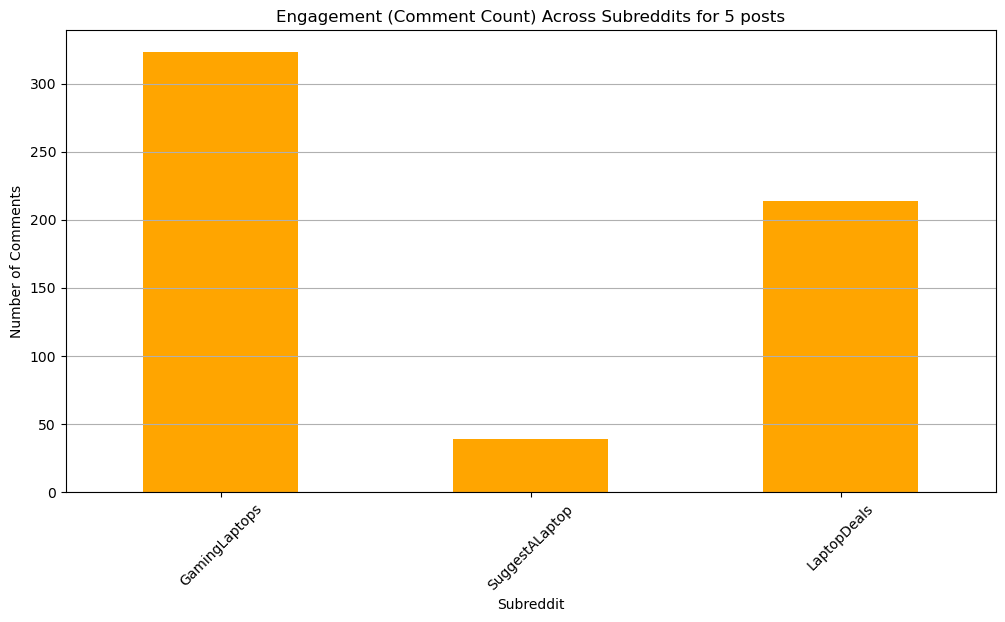

In [9]:
# Visualization: Subreddit Engagement (Comments)
stats_df.set_index("subreddit")["comments"].plot(kind="bar", figsize=(12, 6), color="orange")
plt.title("Engagement (Comment Count) Across Subreddits for 5 posts")
plt.xlabel("Subreddit")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

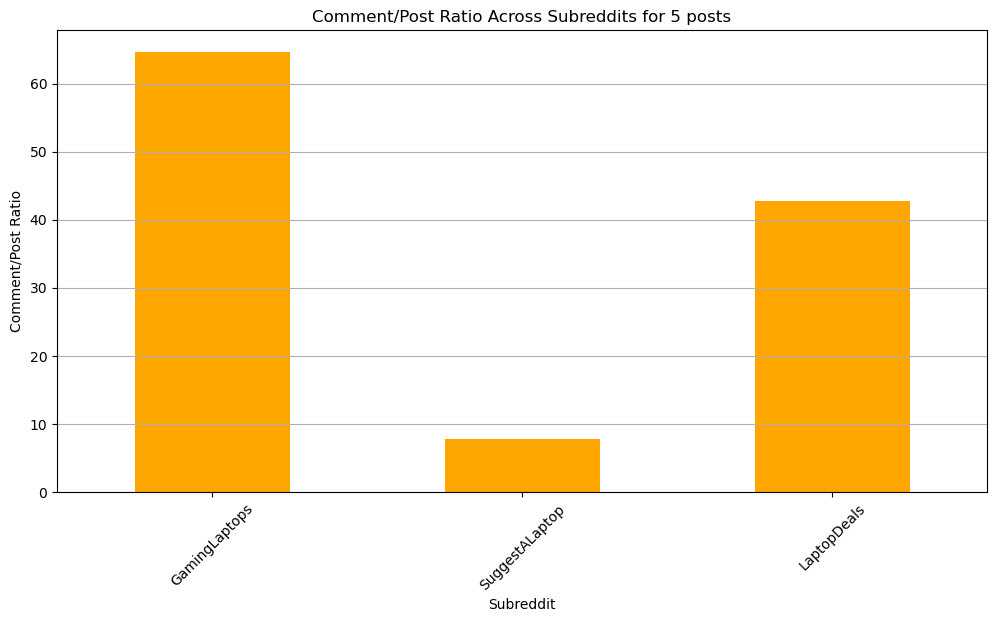

In [10]:
# Visualization: Subreddit Engagement (Comment-Post Ratio)
stats_df.set_index("subreddit")["comment_post_ratio"].plot(kind="bar", figsize=(12, 6), color="orange")
plt.title("Comment/Post Ratio Across Subreddits for 5 posts")
plt.xlabel("Subreddit")
plt.ylabel("Comment/Post Ratio")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [11]:
# Categorize Users by Karma
def categorize_user(karma):
    if karma <= 1000:
        return "Lurker"
    elif 1001 <= karma <= 10000:
        return "Regular"
    else:
        return "Superuser"
    
df["category"] = df["karma"].apply(categorize_user)

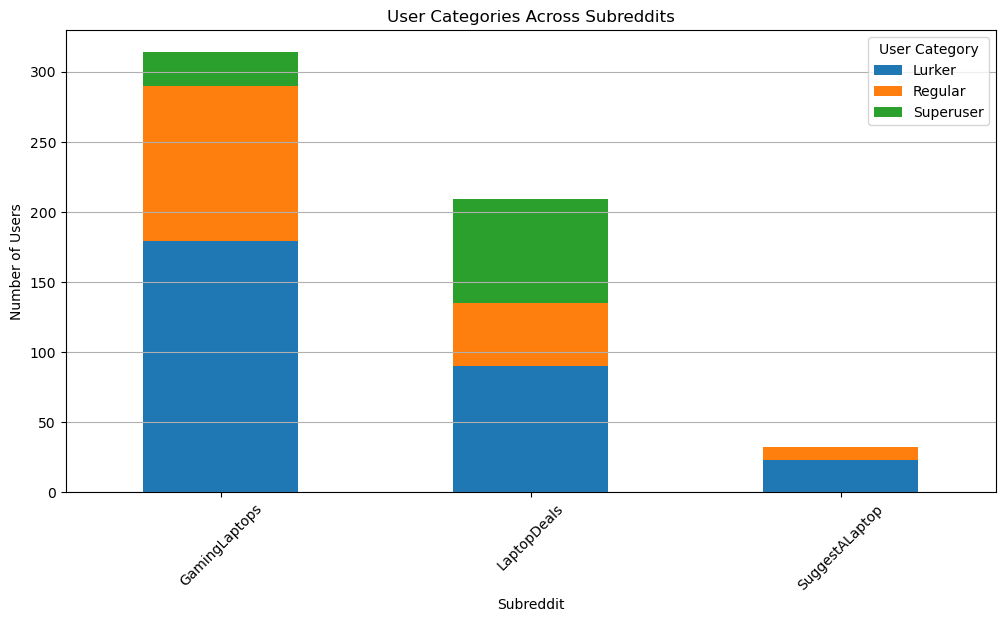

In [12]:
# Visualization After Categorizing Users
def visualize_user_categories(df):
    category_counts = df.groupby(["subreddit", "category"]).size().unstack(fill_value=0)
    category_counts.plot(kind="bar", stacked=True, figsize=(12, 6))
    plt.title("User Categories Across Subreddits")
    plt.xlabel("Subreddit")
    plt.ylabel("Number of Users")
    plt.legend(title="User Category")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

visualize_user_categories(df)

In [13]:
def calculate_weighted_sum(user_df, stats_df, alpha, beta, gamma1, gamma2):
    """
    Calculate weighted sum for each subreddit based on:
    - comment/post ratio (alpha)
    - engagement_rate (beta)
    - Regular users count (gamma1)
    - Superusers count (gamma2)
    """
    category_counts = user_df.groupby(["subreddit", "category"]).size().unstack(fill_value=0)
    stats_df = stats_df.set_index("subreddit")

    # Merge stats with category counts
    merged_df = category_counts.join(stats_df, how="inner")

    # Safe retrieval
    regular_count = merged_df.get("Regular", 0)
    superuser_count = merged_df.get("Superuser", 0)
    comment_post_ratio = merged_df["comment_post_ratio"]
    engagement_rate = merged_df["engagement_rate"]

    # Calculate weighted sum
    merged_df["weighted_sum"] = (
        alpha * comment_post_ratio +
        beta * engagement_rate +
        gamma1 * regular_count +
        gamma2 * superuser_count
    )

    return merged_df

In [14]:
final_df = calculate_weighted_sum(df, stats_df, alpha=2, beta=1000, gamma1=2, gamma2=5)
print("Final Data with Weighted Sum (including engagement_rate):\n", final_df)

best_subreddit = final_df["weighted_sum"].idxmax()
print(f"The best subreddit for marketing is: {best_subreddit}")

Final Data with Weighted Sum (including engagement_rate):
                 Lurker  Regular  Superuser  subscriber_count  posts  comments  \
subreddit                                                                       
GamingLaptops      179      111         24            261651      5       323   
LaptopDeals         90       45         74            123652      5       214   
SuggestALaptop      23        9          0            162366      5        39   

                comment_post_ratio  active_users  engagement_rate  \
subreddit                                                           
GamingLaptops                 64.6           164         0.000627   
LaptopDeals                   42.8            87         0.000704   
SuggestALaptop                 7.8            21         0.000129   

                weighted_sum  
subreddit                     
GamingLaptops     471.826789  
LaptopDeals       546.303587  
SuggestALaptop     33.729337  
The best subreddit for marketing i

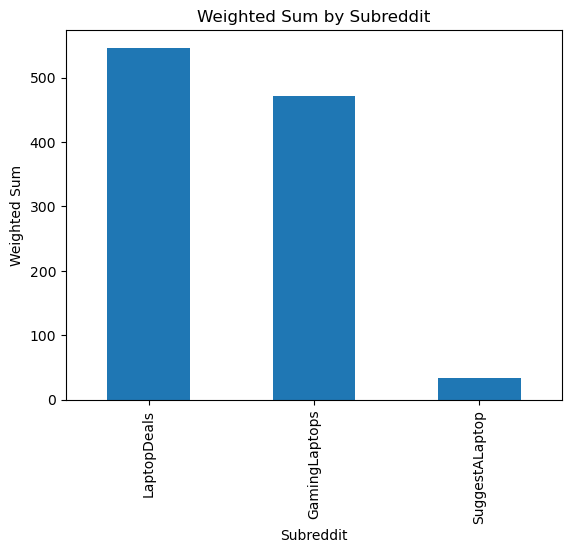

In [15]:
# Sort the DataFrame based on weighted_sum to visualize in descending order
final_df_sorted = final_df.sort_values("weighted_sum", ascending=False)

# Create a bar chart
plt.figure()
final_df_sorted["weighted_sum"].plot(kind="bar")
plt.xlabel("Subreddit")
plt.ylabel("Weighted Sum")
plt.title("Weighted Sum by Subreddit")
plt.show()